In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# explore data
inspector = inspect(engine)
# Get a list of column names and types
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])
# columns

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [9]:
# Get a list of column names and types
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])
# columns

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [12]:
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

('2017-08-23',)


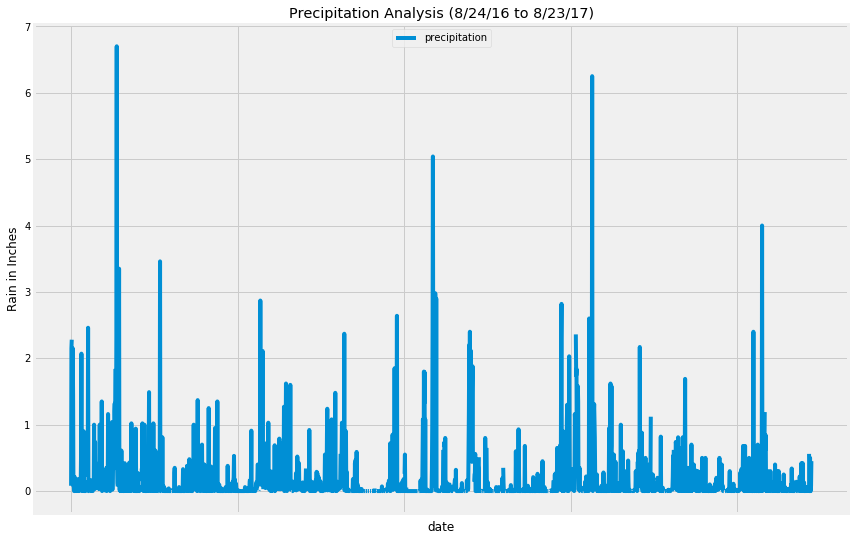

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(last_date)
year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation = session.query(Measurement.date, Measurement.prcp).\
                              filter(Measurement.date>year_ago).order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
prcp_df = pd.DataFrame(precipitation, columns=['date', 'precipitation'])

#set date index
prcp_df.set_index('date', inplace=True, )

# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(figsize=(13,9),title = "Precipitation Analysis (8/24/16 to 8/23/17)")

plt.legend(loc='upper center')
plt.ylabel("Rain in Inches")
plt.show()

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [16]:
# Design a query to show how many stations are available in this dataset?
station_available = session.query(Station.station).count()
stations = session.query(Station.station).all()
print(f"there are {station_available} stations available")

there are 9 stations available


In [17]:
station_nm = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).\
                           order_by(func.count(Measurement.station).desc()).all()
                           
print (station_nm)
# What are the most active stations? (i.e. what stations have the most rows)?
busiest_station = (station_nm[0][0])
print(f"busiest station is {busiest_station}")

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]
busiest station is USC00519281


In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
tempratures = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).all()
tempratures

[(53.0, 87.0, 73.09795396419437)]

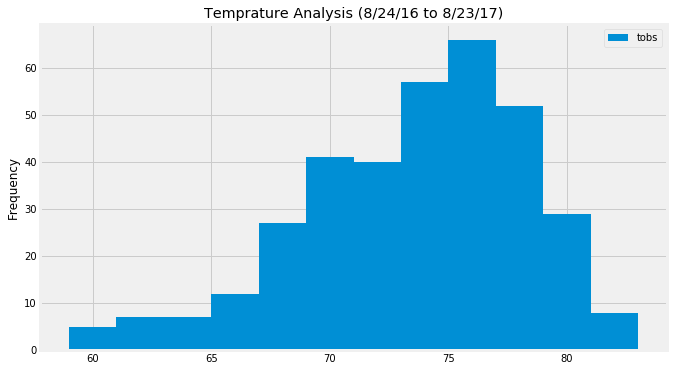

In [101]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_year_ago = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
                              filter(Measurement.date>year_ago).\
                              filter(Measurement.station == busiest_station).order_by(Measurement.date).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
temp_df = pd.DataFrame(temp_year_ago, columns=['station', 'date', 'tobs'])

#set date index
temp_df.set_index('date', inplace=True, )

# Use Pandas Plotting with Matplotlib to plot the data
temp_df.plot(kind="hist", figsize=(10,6),title = "Temprature Analysis (8/24/16 to 8/23/17)", bins=12)
plt.ylabel("Frequency")
plt.show()

In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
vacation_temp=calc_temps('2017-02-28', '2017-03-05')
print(vacation_temp)

[(64.0, 72.02777777777777, 78.0)]


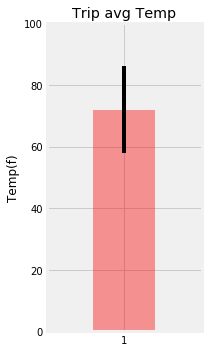

In [22]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
y_rr=vacation_temp[0][2]-vacation_temp[0][0]
fig, ax = plt.subplots(figsize=(3,5))
ax.bar(1, vacation_temp[0][1], yerr=y_rr, color="red",alpha=0.4, tick_label=1)
ax.set_ylim(0,100)
plt.xlim(0,2)
plt.title("Trip avg Temp")
plt.ylabel("Temp(f)")
fig.tight_layout()

In [103]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rain = session.query(Measurement.station,Station.name, Station.latitude, Station.longitude, Measurement.prcp).\
                     filter(Measurement.station == Station.station).\
                     filter(Measurement.date >= dt.date(2017, 2, 28)).\
                     filter(Measurement.date <= dt.date(2017, 3, 5)).\
                     group_by(Measurement.prcp).\
                     order_by(Measurement.prcp.desc()).all()
rain

[('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 2.4),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 2.2),
 ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 2.12),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 2.0),
 ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 1.88),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  1.48),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 1.45),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 1.19),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  1.12),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 0.73),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  0.59),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 0.58),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 0.56),
 ('U

In [33]:
vacation_data_df=pd.DataFrame(rain)


In [34]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [93]:
#list of daily_normals
list=[]
dates=[]
#iterate through the vacation dates and get the daily_normals
for single_date in (dt.date(2017, 2, 28) + dt.timedelta(n) for n in range(6)):
    dates.append(single_date)
    month_day=func.strftime("%m-%d",single_date)
    list.append(daily_normals(month_day))
print(list)

[[(65.0, 70.65517241379311, 80.0)], [(64.0, 70.0327868852459, 76.0)], [(61.0, 70.36666666666666, 78.0)], [(60.0, 70.06896551724138, 78.0)], [(57.0, 69.27272727272727, 77.0)], [(60.0, 67.89090909090909, 76.0)]]


In [79]:
#creat dataframe for vacations days daily_normals
daily_n_df=pd.DataFrame(columns=['Min','Avg','Max'])
for n in range(6):
    df2=pd.DataFrame(list[n],columns=['Min','Avg','Max'])
    daily_n_df=daily_n_df.append(df2, ignore_index=True)
    n=n+1
daily_n_df

,Min,Avg,Max
0,65.0,70.655172,80.0
1,64.0,70.032787,76.0
2,61.0,70.366667,78.0
3,60.0,70.068966,78.0
4,57.0,69.272727,77.0
5,60.0,67.890909,76.0


[None, None, None, None, None, None, None, None, None, None, None, None]

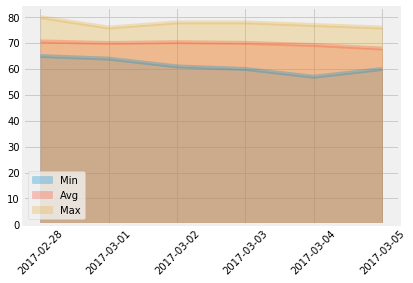

In [99]:
# Plot the daily normals as an area plot with `stacked=False`
daily_n_df.plot.area(alpha=0.3,stacked=False)
x = range(len(dates))
plt.xticks(x,  dates)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)